In [4]:
from google.colab import drive
from pathlib import Path

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.mount(str(drive_path))
project_path = drive_path / 'MyDrive' / 'Colab Notebooks' / 'super_resolution'
print(project_path)
%cd "{project_path}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/super_resolution
/content/drive/MyDrive/Colab Notebooks/super_resolution


In [5]:
!ls

 best_model_improved.h5				        DIV2K_train_HR	       FSRCNN.ipynb
'Copy of FSRCNN_FAST.ipynb'			        DIV2K_train_HR.zip.1   model2_FCN_FSRCNN.h5
'Copy of FSRCNN_SKIP_CONNECTION_DIV2K_DATASETS.ipynb'   FSRCN-Keras	       SRCNN-Keras


In [ ]:
############### IF YOU DON'T WANT TO TRAIN :
############### Load my github model and use the output patch prediction and merging code from this same notebook lateron

In [7]:
DATADIR = "SRCNN-Keras/yang91"
DATADIR2 = "SRCNN-Keras/yang91"
#DATADIR2 = "DIV2K_train_HR"


In [8]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [9]:
scale = 2
req_size = 20
inp_size = int(req_size/scale)
stride = 15

X=[]
labels=[]

for filera in os.listdir(DATADIR):
  readpath = os.path.join(DATADIR,filera)
  img = cv2.imread(readpath)
  img = np.asarray(img)
  shapes = img.shape
  for i in range(0, shapes[0]-req_size+1, stride):
    for j in range(0, shapes[1]-req_size+1,stride):
      subimage_HR = img[i:i+req_size, j:j+req_size]
      #cv2_imshow(subimage_HR)
      subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
      X.append(subimage_LR)
      labels.append(subimage_HR)

counta=0
for filera in os.listdir(DATADIR2):
  counta=counta+1
  if(counta==300):
    break
  readpath = os.path.join(DATADIR2,filera)
  img = cv2.imread(readpath)
  img = np.asarray(img)
  shapes = img.shape
  for i in range(0, shapes[0]-req_size+1, stride):
    for j in range(0, shapes[1]-req_size+1,stride):
      subimage_HR = img[i:i+req_size, j:j+req_size]
      #cv2_imshow(subimage_HR)
      subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
      X.append(subimage_LR)
      labels.append(subimage_HR)

In [10]:
X = np.asarray(X)
labels = np.asarray(labels)
print(labels.shape)
print(X.shape)

(37698, 20, 20, 3)
(37698, 10, 10, 3)


In [11]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input,Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD

In [12]:
alpha = 0.85
def basic_mse(y_true, y_pred):
  pred = tf.image.sobel_edges(y_pred)
  true = tf.image.sobel_edges(y_true)
  lossmse = tf.reduce_mean(tf.square(y_pred-y_true))
  lossedge = tf.reduce_mean(tf.square(pred-true))
  return alpha*lossmse + (1-alpha)*lossedge

In [ ]:
d=64
s=12
m=3

In [15]:
d=64
s=12
m=5

inputlayer = tf.keras.layers.Input(shape=(None,None,3))
x = Conv2D(filters=d, strides=(1,1), kernel_size=7 ,padding="same")(inputlayer)
x = LeakyReLU(alpha=0.2)(x)

#the layer to reduce feature maps from d to s
x = Conv2D(filters=s, kernel_size=(1, 1),padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)

#the middle m layers
for i in range(m):
  x = Conv2D(filters=s,kernel_size=(3, 3),padding="same")(x)
  x = LeakyReLU(alpha=0.1)(x)

x = Conv2D(filters=d, kernel_size=(1, 1), padding="same")(x)
x = LeakyReLU(alpha=0.1)(x)


#final expanding layer of the model 3 channels for RGB
y = Conv2DTranspose(filters=3, kernel_size = (9,9), strides = (scale,scale), padding="same",activation=None)(x)

model = Model(inputs=inputlayer , outputs = y)

In [16]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD

In [17]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 64)    9472      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, None, None, 64)    0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 12)    780       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, None, None, 12)    0         
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 12)    1308      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, None, None, 12)    0   

In [18]:
checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made
                                          # automatically depending on the quantity to monitor

In [19]:
history = model.fit(X,labels,batch_size=16,shuffle=True,validation_split=0.01 ,epochs=20,callbacks=[checkpoint],
                    verbose=1 )

Epoch 1/20
2333/2333 [==============================] - 29s 7ms/step - loss: 574.8995 - accuracy: 0.8244 - val_loss: 440.4435 - val_accuracy: 0.9311
Epoch 2/20
   9/2333 [..............................] - ETA: 15s - loss: 160.9370 - accuracy: 0.8982

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2333/2333 [==============================] - 17s 7ms/step - loss: 136.7519 - accuracy: 0.9179 - val_loss: 350.5892 - val_accuracy: 0.9405
Epoch 3/20
2333/2333 [==============================] - 16s 7ms/step - loss: 115.3769 - accuracy: 0.9244 - val_loss: 339.2572 - val_accuracy: 0.9383
Epoch 4/20
2333/2333 [==============================] - 15s 6ms/step - loss: 105.7343 - accuracy: 0.9312 - val_loss: 374.6323 - val_accuracy: 0.7895
Epoch 5/20
2333/2333 [==============================] - 15s 7ms/step - loss: 99.8577 - accuracy: 0.9357 - val_loss: 308.4643 - val_accuracy: 0.9526
Epoch 6/20
2333/2333 [==============================] - 15s 6ms/step - loss: 95.2033 - accuracy: 0.9390 - val_loss: 309.6588 - val_accuracy: 0.9485
Epoch 7/20
2333/2333 [==============================] - 16s 7ms/step - loss: 92.4773 - accuracy: 0.9400 - val_loss: 303.3676 - val_accuracy: 0.9405
Epoch 8/20
2333/2333 [==============================] - 15s 7ms/step - loss: 90.9034 - accuracy: 0.9418 - val_loss: 300.

In [20]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Loss Curves')

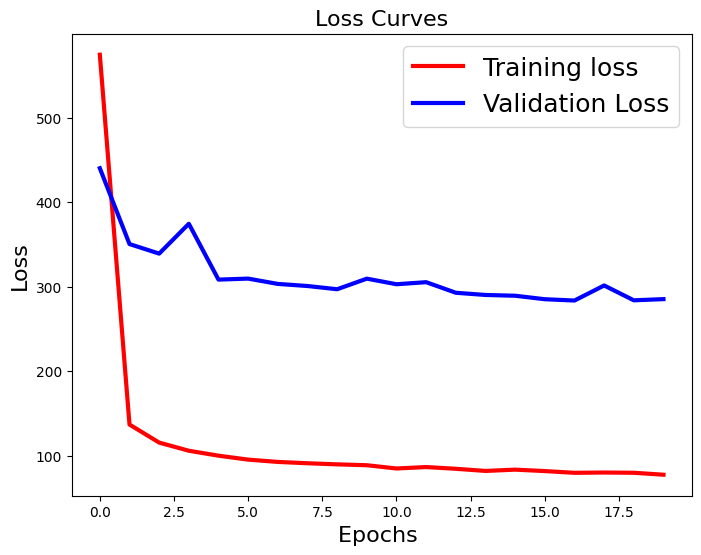

In [21]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

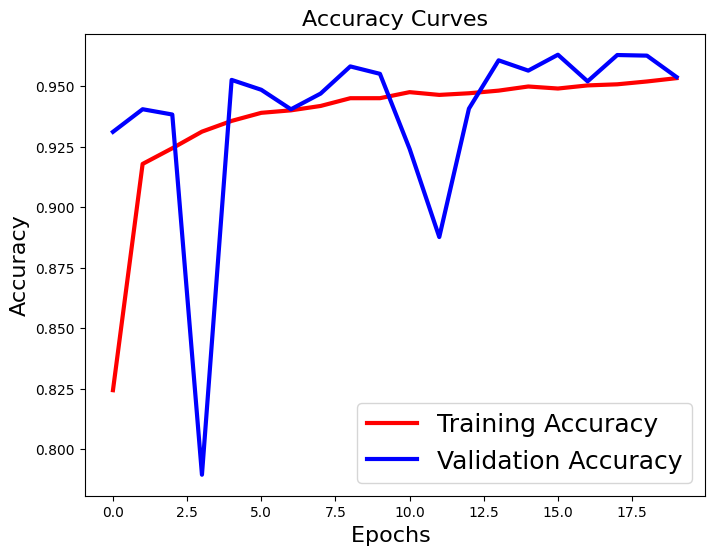

In [22]:
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [23]:
def psnr_calc():
  testimg = []
  #GT = cv2.imread("/content/drive/My Drive/dataset/suparesthing/test/set5/butterfly.png")
  GT = cv2.imread("SRCNN-Keras/baby_x2_GT.png")
  GT = np.asarray(GT)
  h = GT.shape[0]
  l = GT.shape[1]
  #print(GT.shape)
  img1 = cv2.resize(GT,(int(l/2),int(h/2)),interpolation = cv2.INTER_CUBIC)
  print(img1.shape)
  img1 = np.asarray(img1)
  testimg.append(img1)
  testimg = np.asarray(testimg)
  print(testimg.shape)
  fin =(model.predict(testimg)[0])
  print(fin.shape)
  inp = cv2.resize(img1,(l,h),interpolation = cv2.INTER_CUBIC)
  GT = GT[0:fin.shape[0],0:fin.shape[1],:]
  #mse = np.square(np.subtract(GT,inp)).mean()
  mse = np.square(np.subtract(GT, fin)).mean()
  cv2_imshow(inp)
  cv2_imshow(fin)
  cv2_imshow(GT)
  import math
  psnr = 20*math.log(255.0,10) - 10*(math.log(mse,10))
  return psnr

(256, 256, 3)
(1, 256, 256, 3)
1/1 [==============================] - 0s 468ms/step
(512, 512, 3)


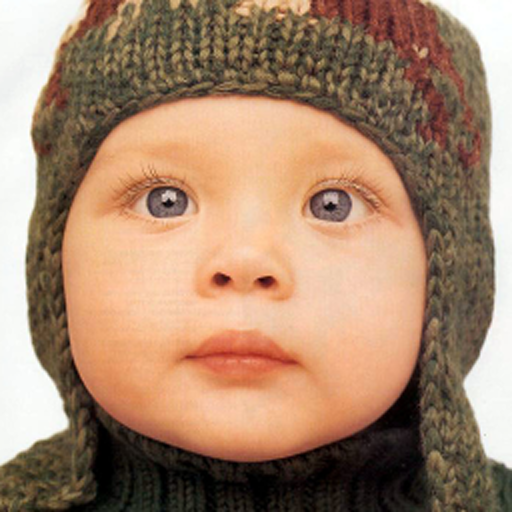

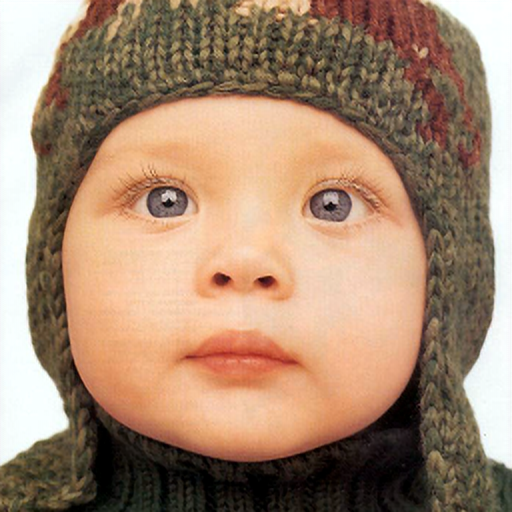

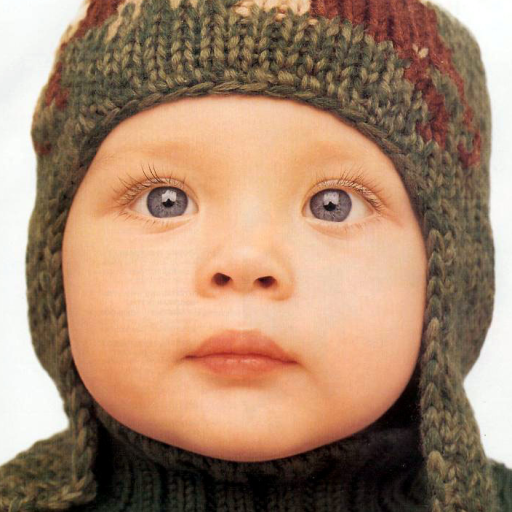

33.226820916577424


In [24]:
ps1 = psnr_calc()
print(ps1)

In [ ]:
34.99243854909264

In [26]:
model.save("model3_FCN_FSRCNN.h5")